In [1]:
# Version requirements: Python 3.14.2, numpy 2.3.5, matplotlib 3.10.8, pywt 1.8.0, scipy 1.16.3
import numpy as np
import matplotlib.pyplot as plt
import pywt

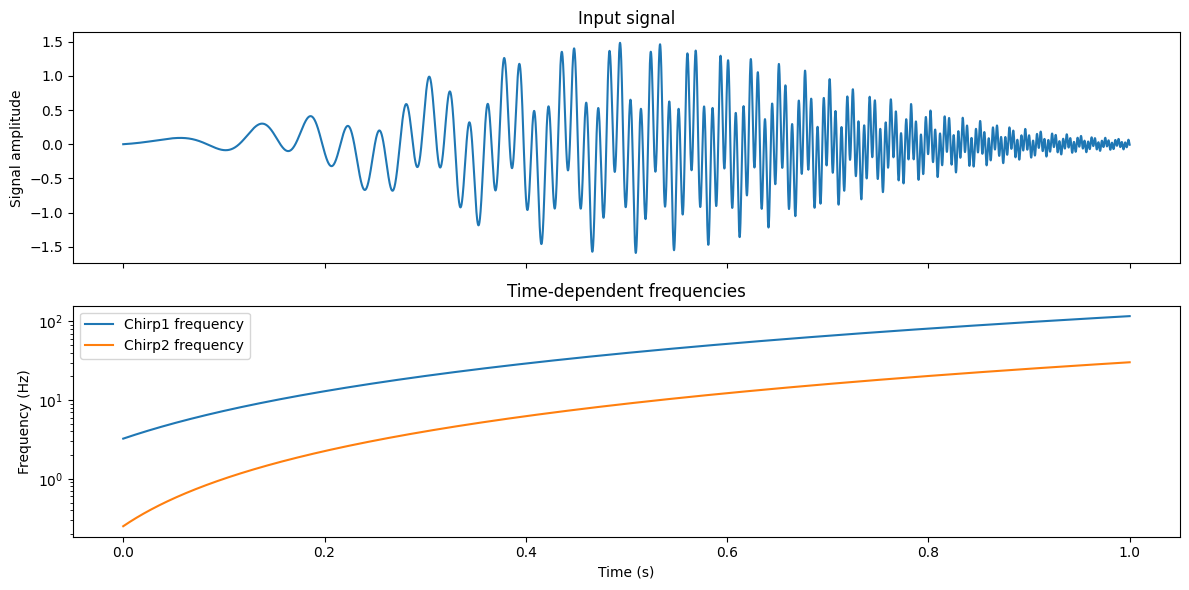

In [ ]:
# Define your functions
def gaussian(x, x0, sigma):
    return np.exp(-np.power((x - x0) / sigma, 2.0) / 2.0)

# Create chirp signal, which is the sum of two signals with time-dependent frequencies
def make_chirp(t, t0, a):
    frequency = (a * (t + t0)) ** 2
    chirp = np.sin(2 * np.pi * frequency * t)
    return chirp, frequency

# Generate signal
time = np.linspace(0, 1, 8048)
chirp1, frequency1 = make_chirp(time, 0.2, 9)
chirp2, frequency2 = make_chirp(time, 0.1, 5)
chirp = chirp1 + 0.6 * chirp2
chirp *= gaussian(time, 0.5, 0.2)
# Plot signal and frequency components
fig, axs = plt.subplots(2, 1, sharex=True, figsize=(12,6))
axs[0].plot(time, chirp)
axs[0].set_ylabel("Signal amplitude")
axs[0].set_title("Input signal")

axs[1].plot(time, frequency1, label="Chirp1 frequency")
axs[1].plot(time, frequency2, label="Chirp2 frequency")
axs[1].set_yscale("log")
axs[1].set_xlabel("Time (s)")
axs[1].set_ylabel("Frequency (Hz)")
axs[1].legend()
axs[1].set_title("Time-dependent frequencies")

plt.tight_layout()
plt.show()

Type of signal: <class 'numpy.ndarray'>


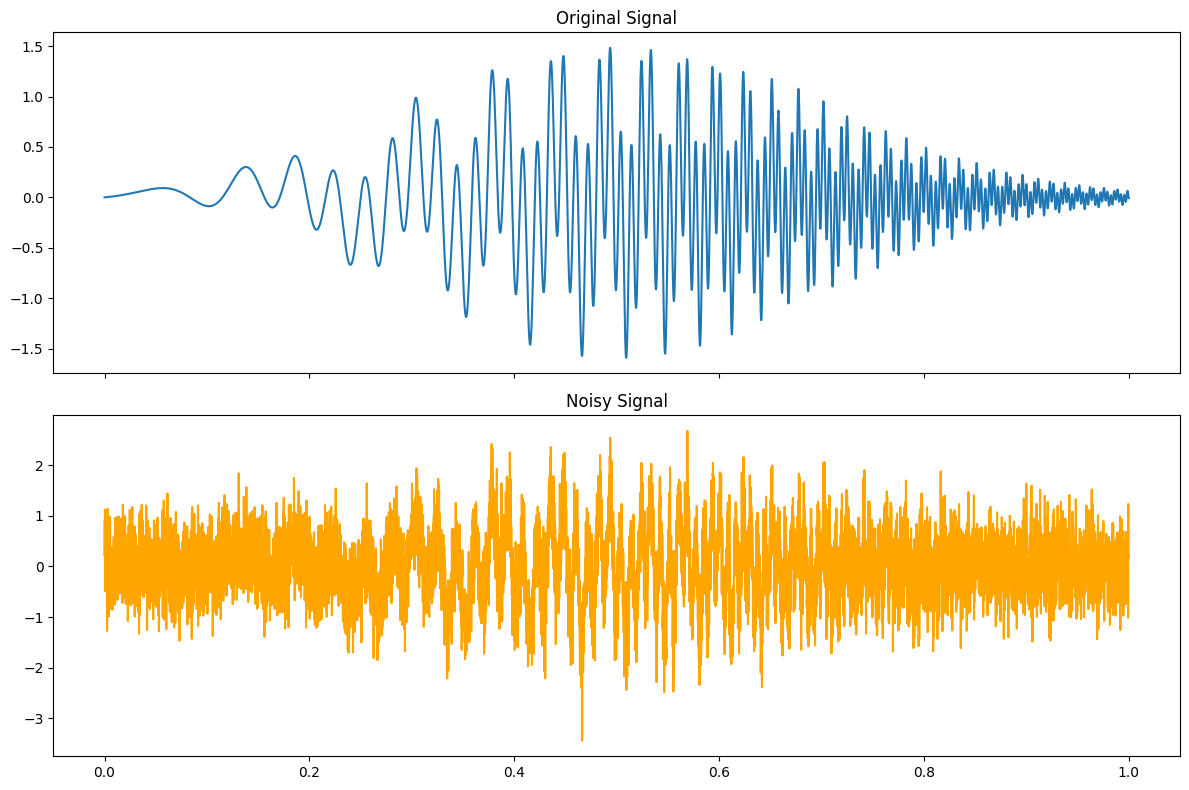

In [7]:
signal = (chirp1+0.6*chirp2) * gaussian(time, 0.5, 0.2)
print("Type of signal:", type(signal))
# Add noise
np.random.seed(0)
noisy_signal = signal + 0.5 * np.random.normal(size=signal.shape)

def wavelet_denoise(signal, wavelet_name = 'db4', level=5, threshold=0.2):
    coeffs = pywt.wavedec(signal, wavelet_name, level=level)
    # Apply thresholding to detail coefficients
    coeffs_thresholded = [coeffs[0]] + [pywt.threshold(c, threshold, mode='soft') for c in coeffs[1:]]
    # Reconstruct the signal
    denoised_signal = pywt.waverec(coeffs_thresholded, wavelet_name)
    return denoised_signal

# Plot the signal
fig, axs = plt.subplots(2, 1, sharex=True, figsize=(12,8))
axs[0].plot(time, signal, label='Original Signal')
axs[0].set_title('Original Signal')
axs[1].plot(time, noisy_signal, label='Noisy Signal', color='orange')
axs[1].set_title('Noisy Signal')
plt.tight_layout()
plt.show()

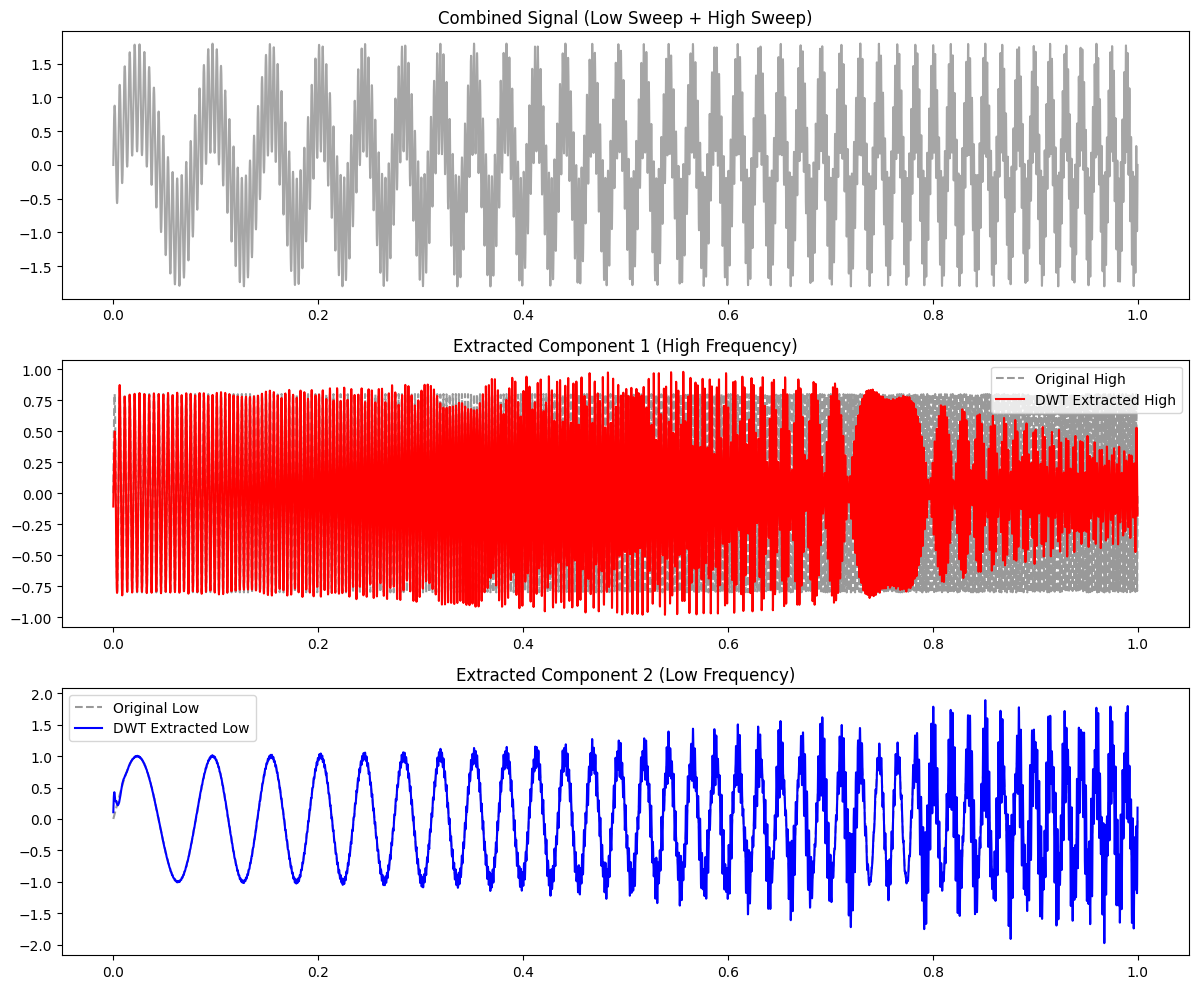

In [ ]:
fs = 8048  # Sampling frequency
time = np.linspace(0, 1, fs)

# Component 1: Low frequency (stays in the 'Approximation' / deep detail levels)
# A sweep from 10Hz to 40Hz
low_freq_chirp = np.sin(2 * np.pi * (10 + 30 * time) * time)

# Component 2: High frequency (stays in the 'Fine' detail levels)
# A sweep from 200Hz to 400Hz
high_freq_chirp = 0.8 * np.sin(2 * np.pi * (200 + 200 * time) * time)

combined_signal = low_freq_chirp + high_freq_chirp
wavelet = 'sym8'
level = 5
coeffs = pywt.wavedec(combined_signal, wavelet, level=level)

# 3. Targeted Reconstruction

# Isolate HIGH component (Detail levels D1 and D2 usually cover the top quarter of spectrum)
high_mask = [np.zeros_like(c) for c in coeffs]
high_mask[1] = coeffs[1] # D1
high_mask[2] = coeffs[2] # D2
recon_high = pywt.waverec(high_mask, wavelet)[:fs]

# Isolate LOW component (The remaining levels + Approximation)
low_mask = [np.zeros_like(c) for c in coeffs]
for i in range(3, len(coeffs)): # D3, D4, D5
    low_mask[i] = coeffs[i]
low_mask[0] = coeffs[0] # A5
recon_low = pywt.waverec(low_mask, wavelet)[:fs]

# 4. Plotting
plt.figure(figsize=(12, 10))

# Subplot 1: Combined Input
plt.subplot(3, 1, 1)
plt.plot(time, combined_signal, color='gray', alpha=0.7)
plt.title("Combined Signal (Low Sweep + High Sweep)")

# Subplot 2: Extracted High Frequency
plt.subplot(3, 1, 2)
plt.plot(time, high_freq_chirp, 'k--', alpha=0.4, label="Original High")
plt.plot(time, recon_high, 'r', label="DWT Extracted High")
plt.title("Extracted Component 1 (High Frequency)")
plt.legend()

# Subplot 3: Extracted Low Frequency
plt.subplot(3, 1, 3)
plt.plot(time, low_freq_chirp, 'k--', alpha=0.4, label="Original Low")
plt.plot(time, recon_low, 'b', label="DWT Extracted Low")
plt.title("Extracted Component 2 (Low Frequency)")
plt.legend()

plt.tight_layout()
plt.show()

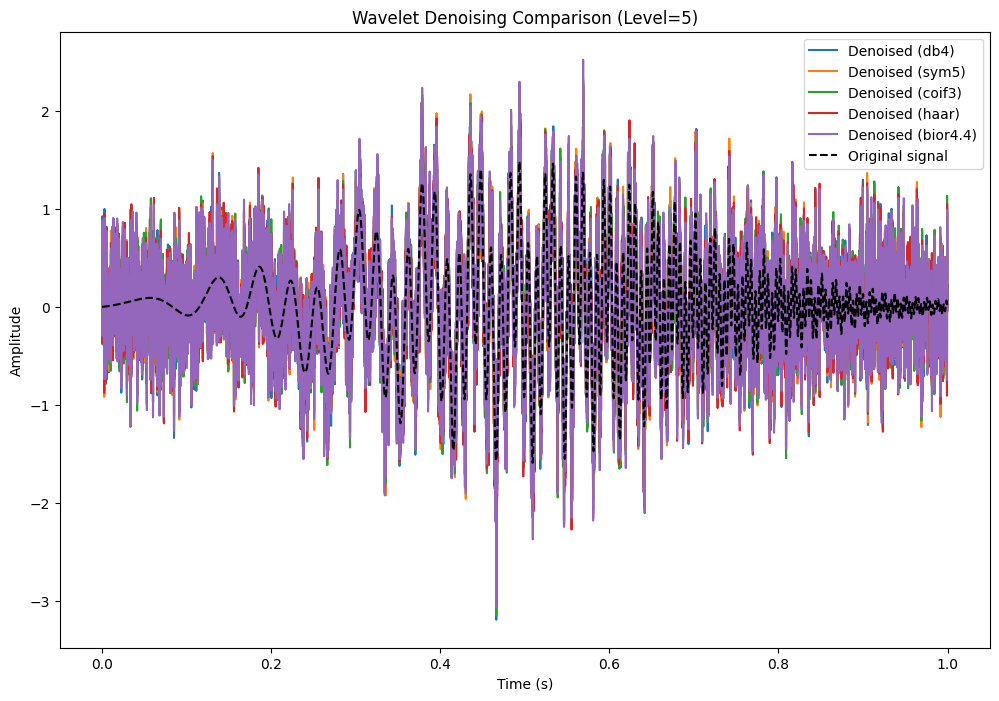

In [9]:
# Compare different discreete wavelets on the noisy signal
wavelets_to_test = ['db4', 'sym5', 'coif3', 'haar', 'bior4.4']
level = 5


plt.figure(figsize=(12,8))
#plt.plot(time, noisy_signal, label='Noisy signal', color='gray', alpha=0.6)

for w in wavelets_to_test:
    denoised = wavelet_denoise(noisy_signal, wavelet_name=w, level=level)
    plt.plot(time, denoised, label=f'Denoised ({w})')

plt.plot(time, signal, '--', color='black', label='Original signal')
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title(f'Wavelet Denoising Comparison (Level={level})')
plt.legend()
plt.show()


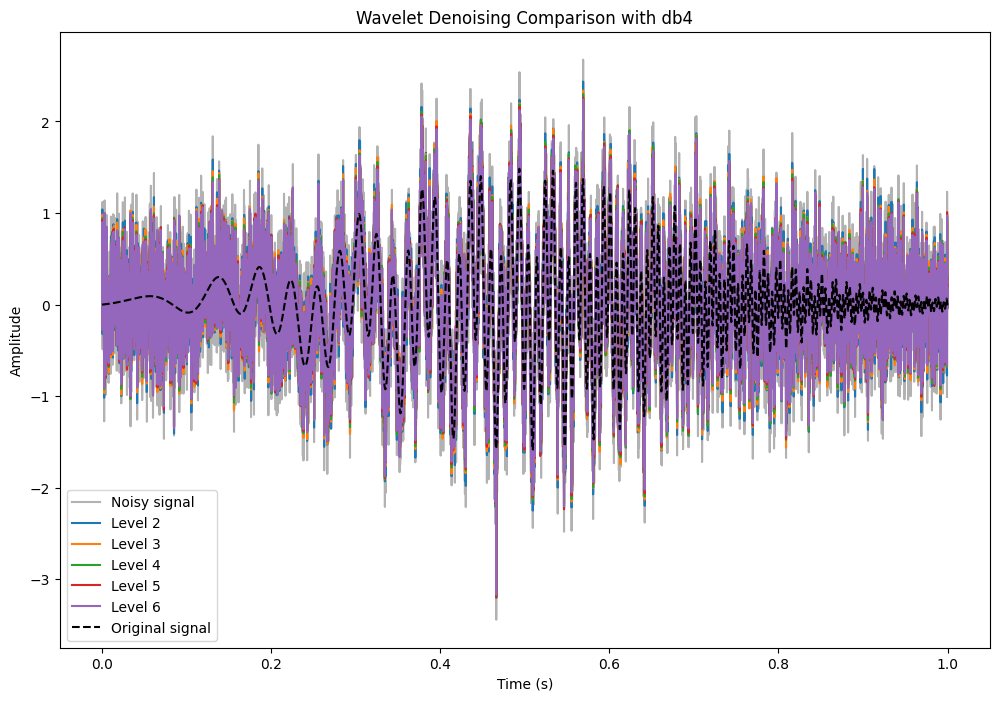

In [ ]:
# Compare different decomposition levels
levels = [2, 3, 4, 5, 6]
wavelet = 'db4'

plt.figure(figsize=(12,8))
plt.plot(time, noisy_signal, label='Noisy signal', color='gray', alpha=0.6)

for l in levels:
    denoised = wavelet_denoise(noisy_signal, wavelet_name=wavelet, level=l)
    plt.plot(time, denoised, label=f'Level {l}')

plt.plot(time, signal, '--', color='black', label='Original signal')
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title(f'Wavelet Denoising Comparison with {wavelet}')
plt.legend()
plt.show()

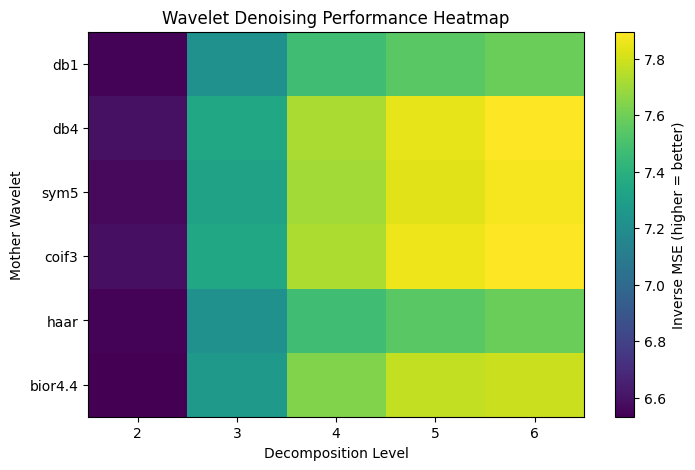

In [ ]:
# Define wavelets and levels to test
wavelets = ['db1','db4', 'sym5', 'coif3', 'haar', 'bior4.4']
levels = [2, 3, 4, 5, 6]

# Compute similarity (inverse MSE)
heatmap = np.zeros((len(wavelets), len(levels)))

for i, w in enumerate(wavelets):
    for j, l in enumerate(levels):
        denoised = wavelet_denoise(noisy_signal, wavelet_name=w, level=l)
        mse = np.mean((signal - denoised)**2)
        heatmap[i, j] = 1 / (mse + 1e-8)  # higher = better

# Plot heatmap
plt.figure(figsize=(8,5))
im = plt.imshow(heatmap, aspect='auto', cmap='viridis')
plt.colorbar(im, label='Inverse MSE (higher = better)')
plt.xticks(ticks=np.arange(len(levels)), labels=levels)
plt.yticks(ticks=np.arange(len(wavelets)), labels=wavelets)
plt.xlabel("Decomposition Level")
plt.ylabel("Mother Wavelet")
plt.title("Wavelet Denoising Performance Heatmap")
plt.show()

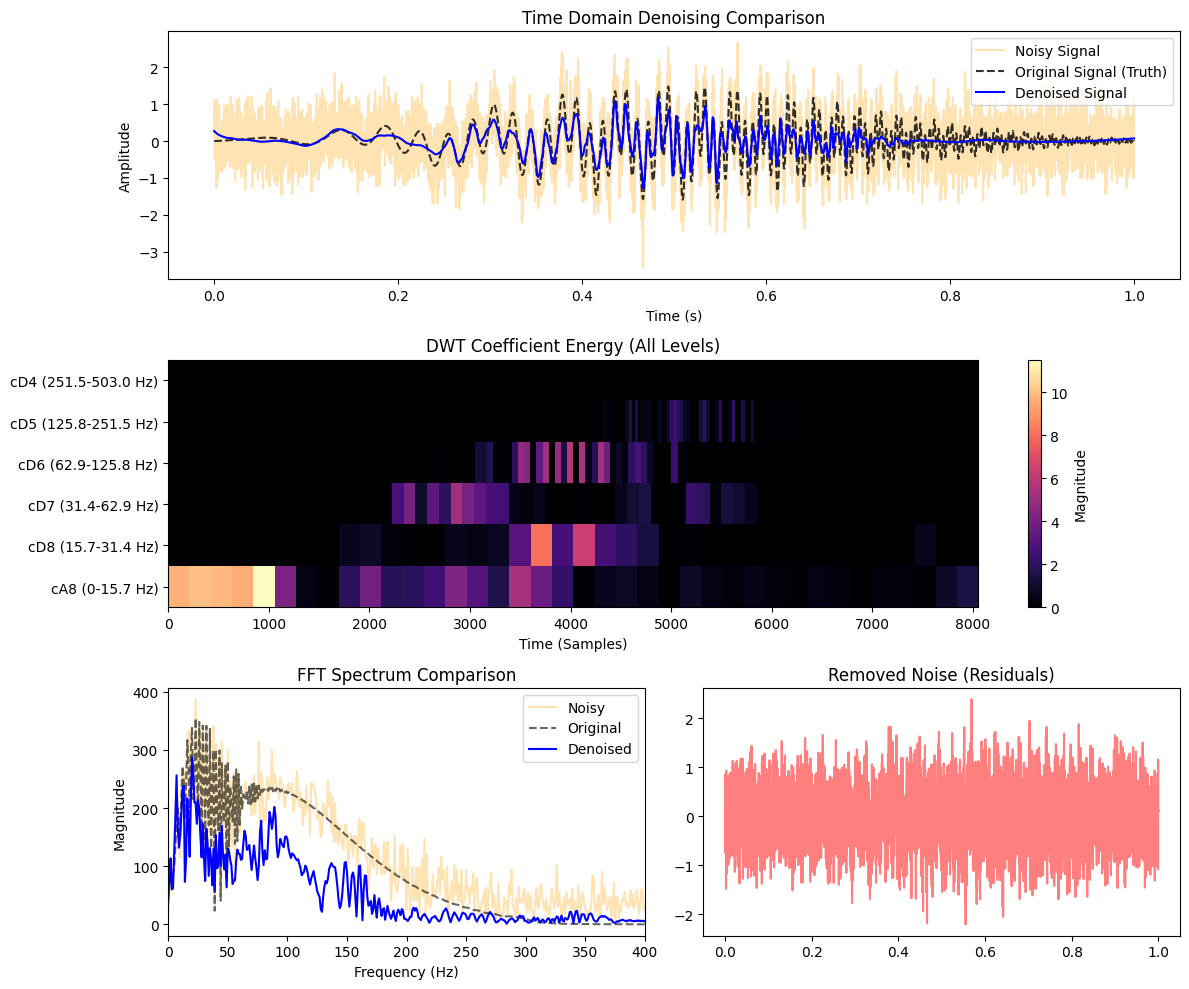

In [ ]:
# 1. Setup
N = 8048   
fs = 8048
time = np.linspace(0, 1, N)
wavelet = 'db4'
level = 8 # Deeper levels to see 0-200Hz better

# 2. Decompose & Denoise
coeffs = pywt.wavedec(noisy_signal, wavelet, level=level)
sigma = np.median(np.abs(coeffs[-1])) / 0.6745
threshold = sigma * np.sqrt(2 * np.log(N)) # Universal threshold

# Denoise all detail levels
denoised_coeffs = [coeffs[0]] 
for i in range(1, len(coeffs)):
    denoised_coeffs.append(pywt.threshold(coeffs[i], threshold, mode='soft'))

denoised_signal = pywt.waverec(denoised_coeffs, wavelet)[:N]


heatmap_list = []
y_labels = []

for i in range(6):
    # Data processing
    data = np.abs(denoised_coeffs[i])
    repeat_factor = int(np.ceil(N / len(data)))
    heatmap_list.append(np.repeat(data, repeat_factor)[:N])
    
    # Frequency Band Labeling
    if i == 0:
        f_low, f_high = 0, fs / 2**(level + 1)
        y_labels.append(f"cA{level} (0-{f_high:.1f} Hz)")
    else:
        # i=1 is cD8, i=8 is cD1
        current_level = level - i + 1
        f_low = fs / 2**(current_level + 1)
        f_high = fs / 2**(current_level)
        y_labels.append(f"cD{current_level} ({f_low:.1f}-{f_high:.1f} Hz)")

# Stack: Index 0 is bottom (low freq), Index -1 is top (high freq)
dwt_matrix = np.vstack(heatmap_list)

# 4. Plotting
fig = plt.figure(figsize=(12, 10))
gs = fig.add_gridspec(3, 2)

# Top: Signals
ax1 = fig.add_subplot(gs[0, :])
ax1.plot(time, noisy_signal, color='orange', alpha=0.3, label='Noisy Signal')
ax1.plot(time, signal, 'k--', alpha=0.8, label='Original Signal (Truth)')
ax1.plot(time, denoised_signal, color='blue', linewidth=1.5, label='Denoised Signal')
ax1.set_title("Time Domain Denoising Comparison")
ax1.set_xlabel("Time (s)")
ax1.set_ylabel("Amplitude")
ax1.legend(loc='upper right')

# Middle: The DWT Heatmap 
ax2 = fig.add_subplot(gs[1, :])
# origin='lower' ensures index 0 (cA8) is at the bottom
im = ax2.imshow(dwt_matrix, aspect='auto', cmap='magma', origin='lower', interpolation='nearest')
ax2.set_yticks(np.arange(len(y_labels)))
ax2.set_yticklabels(y_labels)

ax2.set_ylim(-0.5, len(y_labels) - 0.5) 
ax2.set_title("DWT Coefficient Energy (All Levels)")
ax2.set_xlabel("Time (Samples)")
fig.colorbar(im, ax=ax2, label="Magnitude")

# Bottom Left: FFT
ax3 = fig.add_subplot(gs[2, 0])
xf = np.fft.rfftfreq(N, 1/fs)
yf_orig = np.abs(np.fft.rfft(signal))
yf_noisy = np.abs(np.fft.rfft(noisy_signal))
yf_denoised = np.abs(np.fft.rfft(denoised_signal))

ax3.plot(xf, yf_noisy, color='orange', alpha=0.3, label='Noisy')
ax3.plot(xf, yf_orig, 'k--', alpha=0.6, label='Original')
ax3.plot(xf, yf_denoised, color='blue', label='Denoised')
ax3.set_xlim(0, 400) 
ax3.set_title("FFT Spectrum Comparison")
ax3.set_xlabel("Frequency (Hz)")
ax3.set_ylabel("Magnitude")
ax3.legend()

# Bottom Right: Residuals
ax4 = fig.add_subplot(gs[2, 1])
ax4.plot(time, noisy_signal - denoised_signal, color='red', alpha=0.5)
ax4.set_title("Removed Noise (Residuals)")

plt.tight_layout()
plt.show()

In [14]:
def dwt_compress_global(signal, wavelet='haar', level=2, keep_fraction=0.1):
    # 1. Decompose
    coeffs = pywt.wavedec(signal, wavelet=wavelet, level=level)
    
    # Strategy B: "Fair" Global Compression
    coeff_arr, coeff_slices = pywt.coeffs_to_array(coeffs)
    
    n_keep_total = max(1, int(np.round(len(coeff_arr) * keep_fraction)))
    
    idx = np.argpartition(np.abs(coeff_arr), -n_keep_total)
    compressed_arr = np.zeros_like(coeff_arr)
    compressed_arr[idx[-n_keep_total:]] = coeff_arr[idx[-n_keep_total:]] # Keeping largest coefficients
    
    final_coeffs = pywt.array_to_coeffs(compressed_arr, coeff_slices, output_format='wavedec')
    
    total_kept = n_keep_total

    # 2. Final Reconstruction
    reconstructed = pywt.waverec(final_coeffs, wavelet)[:len(signal)]
    mse = np.mean((signal - reconstructed)**2)
    compression_ratio = 1 - (total_kept / len(signal))
    #print(f"Amount of coefficients kept: {total_kept} out of {len(signal)} for level={level}, fraction={keep_fraction:.3f}")
    
    return reconstructed, compression_ratio, mse, total_kept

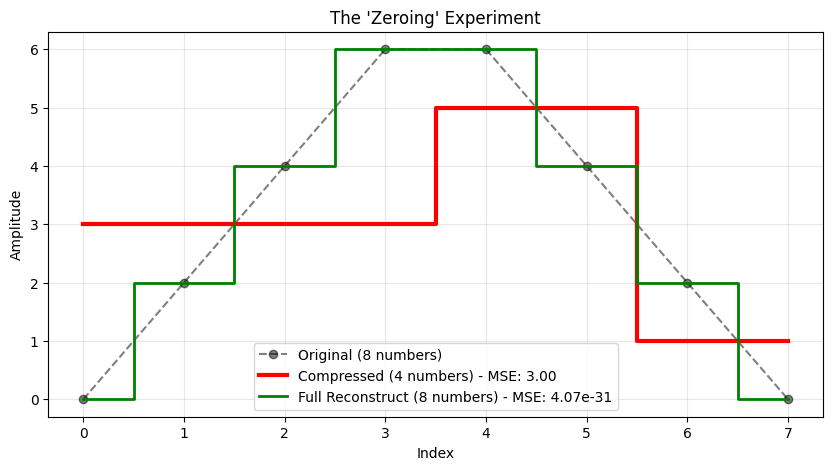

Compression Ratio: 62.5% coefficients discarded
Reconstructed Signal: [3. 3. 3. 3. 5. 5. 1. 1.]


In [15]:
# 1. Define Signal
signal = np.array([0, 2, 4, 6, 6, 4, 2, 0])

# 2. Run the experiment, What happens if we set coefficients to zero?
keep_frac = 2/6 

comp_signal, ratio, mse,_ = dwt_compress_global(
    signal, 
    wavelet='haar', 
    level=2, 
    keep_fraction=keep_frac, 
)

comp_signal_all, ratio_all, mse_all,_ = dwt_compress_global(
    signal, 
    wavelet='haar', 
    level=2, 
    keep_fraction=1.0,

)
# 3. Visualization
plt.figure(figsize=(10, 5))
plt.plot(signal, 'ko--', alpha=0.5, label="Original (8 numbers)")
plt.step(np.arange(8), comp_signal, where='mid', color='red', linewidth=3, 
         label=f"Compressed (4 numbers) - MSE: {mse:.2f}")
plt.step(np.arange(8), comp_signal_all, where='mid', color='green', linewidth=2, 
         label=f"Full Reconstruct (8 numbers) - MSE: {mse_all:.2e}")
plt.title("The 'Zeroing' Experiment")
plt.xlabel("Index")
plt.ylabel("Amplitude")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print(f"Compression Ratio: {ratio*100:.1f}% coefficients discarded")
print(f"Reconstructed Signal: {np.round(comp_signal, 2)}")

Target 5%: Kept 1/8 coeffs. MSE: 9.5000
Target 10%: Kept 1/8 coeffs. MSE: 9.5000
Target 20%: Kept 2/8 coeffs. MSE: 5.0000
Target 50%: Kept 4/8 coeffs. MSE: 1.0000
Target 80%: Kept 6/8 coeffs. MSE: 0.5000


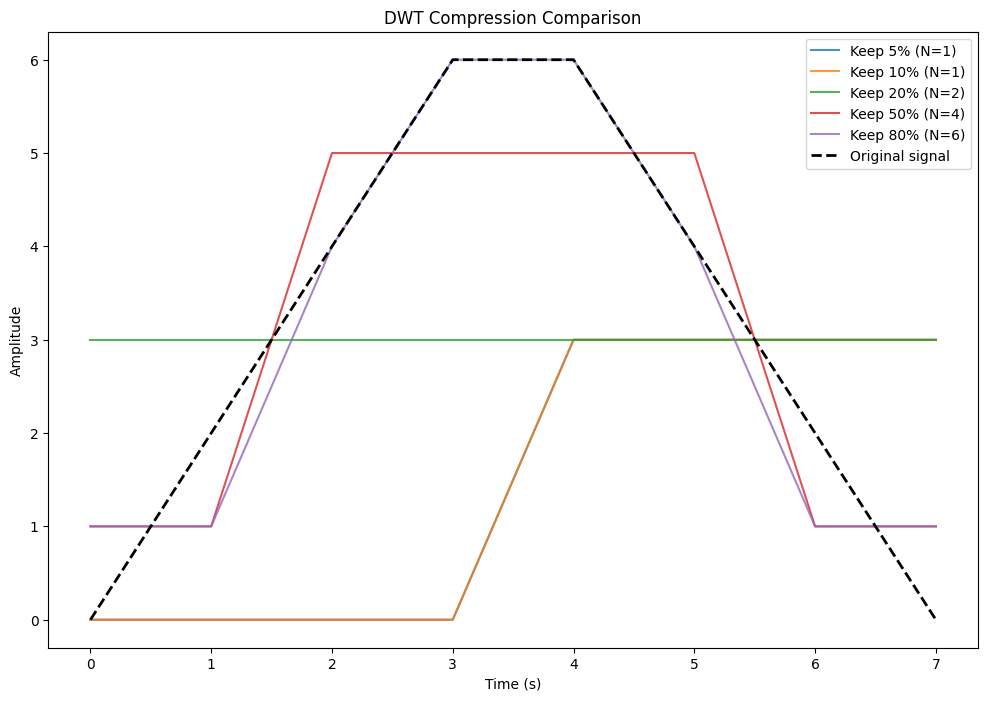

In [ ]:
# Test compression
fractions = [0.05, 0.1, 0.2, 0.5, 0.8]  # keep 5%, 10%, 20%, 50% coefficients
wavelet = 'haar'
level = 2
N_total = len(signal)
time = np.arange(len(signal))
plt.figure(figsize=(12,8))

for f in fractions:
    compressed_signal, cr, mse, n_real = dwt_compress_global(signal, wavelet=wavelet, level=level, keep_fraction=f)
    
    print(f"Target {int(f*100)}%: Kept {n_real}/{N_total} coeffs. MSE: {mse:.4f}")


    plt.plot(np.arange(8), compressed_signal, label=f'Keep {int(f*100)}% (N={n_real})', alpha=0.8)

# Plot original on top
plt.plot(time, signal, color='black', linestyle='--', linewidth=2, label='Original signal')

plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title("DWT Compression Comparison")
plt.legend()
plt.show()

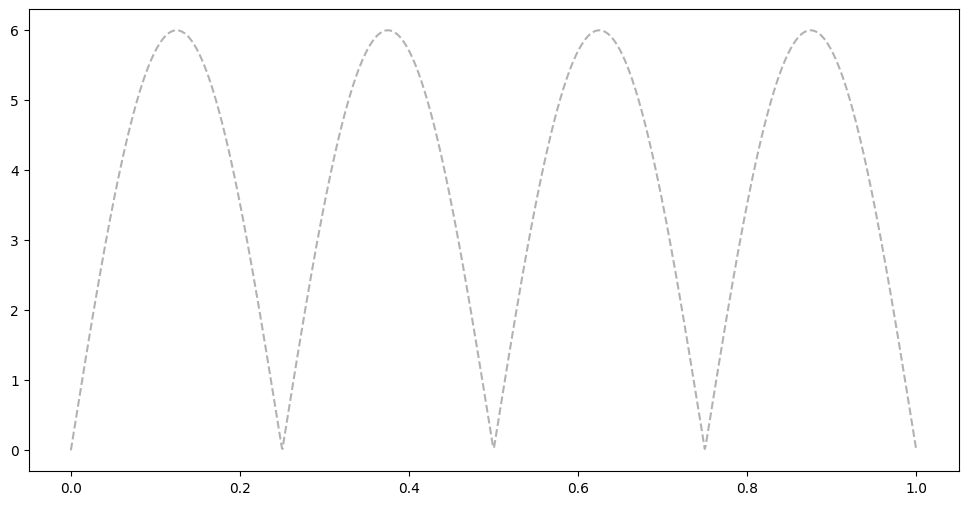

In [ ]:
# 1. Generate Extended Signal (1024 points)
N = 1024
t = np.linspace(0, 1, N)
# A double triangle wave
signal = 6 * np.abs(np.sin(2 * np.pi * 2 * t)) 
noisy_signal = signal + np.random.normal(0, 1.0, size=signal.shape)
plt.figure(figsize=(12, 6))
plt.plot(t, signal, color='black', linestyle='--', alpha=0.3, label='Original')

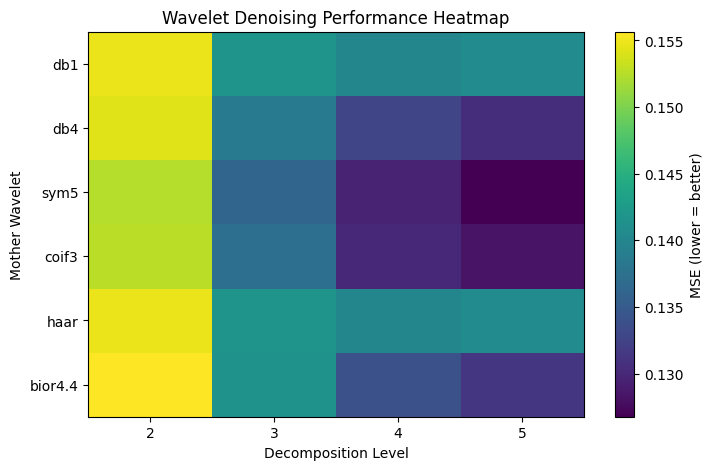

In [ ]:
# Define wavelets and levels to test
wavelets = ['db1','db4', 'sym5', 'coif3', 'haar', 'bior4.4']
levels = [2, 3, 4, 5]

noisy_signal = signal + 0.5 * np.random.normal(size=signal.shape)
# Compute similarity (inverse MSE)
heatmap = np.zeros((len(wavelets), len(levels)))

for i, w in enumerate(wavelets):
    for j, l in enumerate(levels):
        denoised = wavelet_denoise(noisy_signal, wavelet_name=w, level=l)
        mse = np.mean((signal - denoised)**2)
        heatmap[i, j] = mse

# Plot heatmap
plt.figure(figsize=(8,5))
im = plt.imshow(heatmap, aspect='auto', cmap='viridis')
plt.colorbar(im, label='MSE (lower = better)')
plt.xticks(ticks=np.arange(len(levels)), labels=levels)
plt.yticks(ticks=np.arange(len(wavelets)), labels=wavelets)
plt.xlabel("Decomposition Level")
plt.ylabel("Mother Wavelet")
plt.title("Wavelet Denoising Performance Heatmap")
plt.show()

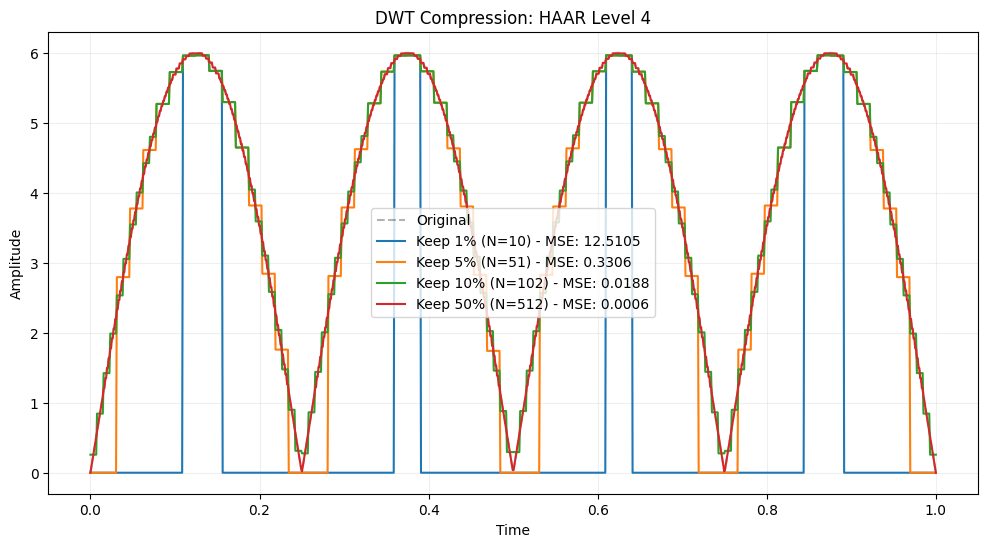

In [ ]:
# 2. Compression Loop for Visualization
fractions = [0.01, 0.05, 0.1, 0.5] 
wavelet = 'haar'
level = 4 # Deeper level possible with 1024 points

plt.figure(figsize=(12, 6))
plt.plot(t, signal, color='black', linestyle='--', alpha=0.3, label='Original')

for f in fractions:
    # Use the dwt_compress_global function defined previously
    comp_sig, cr, mse,_ = dwt_compress_global(signal, wavelet=wavelet, level=level, keep_fraction=f)
    
    # Calculate actual counts for pedagogical clarity
    total_coeffs = N
    kept_count = int(total_coeffs * (1 - cr))
    
    plt.plot(t, comp_sig, label=f'Keep {int(f*100)}% (N={kept_count}) - MSE: {mse:.4f}')

plt.title(f"DWT Compression: {wavelet.upper()} Level {level}")
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.legend()
plt.grid(True, alpha=0.2)
plt.show()

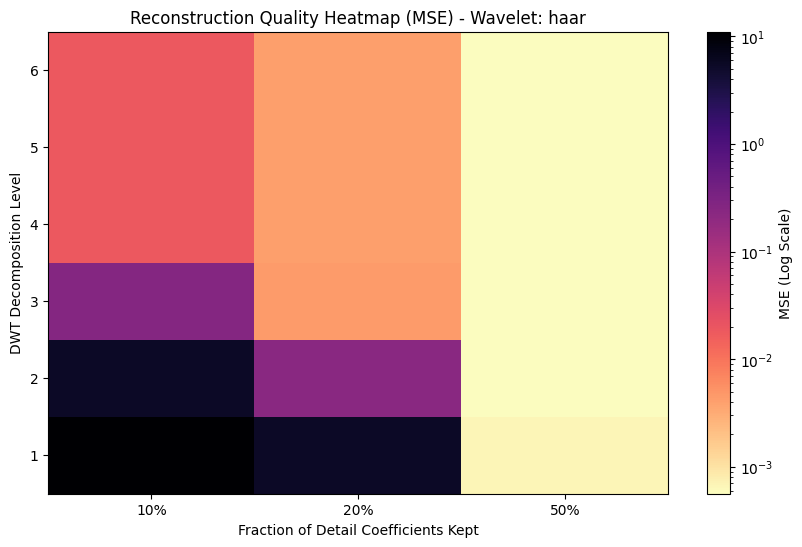

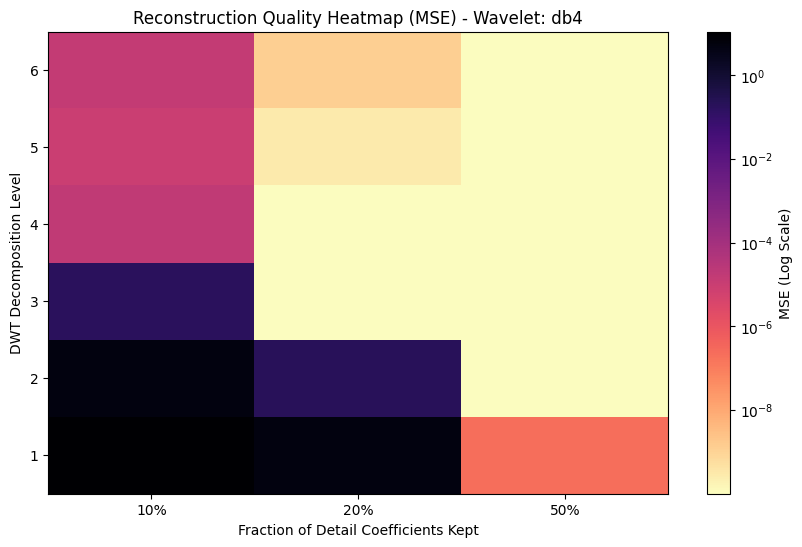

In [ ]:
# Parameters for Heatmap
wavelets_to_test = ['haar', 'db4']
levels = [1, 2, 3, 4, 5, 6]
fractions = [0.1, 0.2, 0.5]

for w in wavelets_to_test:
    mse_heatmap = np.zeros((len(levels), len(fractions)))
    
    for i, l in enumerate(levels):
        for j, f in enumerate(fractions):
            _, _, mse,_ = dwt_compress_global(signal, wavelet=w, level=l, keep_fraction=f)
            mse_heatmap[i, j] = mse
    
    # Plotting
    plt.figure(figsize=(10, 6))
    # We use a LogNorm because MSE often drops exponentially
    from matplotlib.colors import LogNorm
    im = plt.imshow(mse_heatmap, aspect='auto', cmap='magma_r', origin='lower',
                    norm=LogNorm(vmin=mse_heatmap.min() + 1e-10, vmax=mse_heatmap.max()))
    
    plt.colorbar(im, label="MSE (Log Scale)")
    plt.xticks(np.arange(len(fractions)), [f"{int(f*100)}%" for f in fractions])
    plt.yticks(np.arange(len(levels)), levels)
    plt.xlabel("Fraction of Detail Coefficients Kept")
    plt.ylabel("DWT Decomposition Level")
    plt.title(f"Reconstruction Quality Heatmap (MSE) - Wavelet: {w}")
    plt.show()

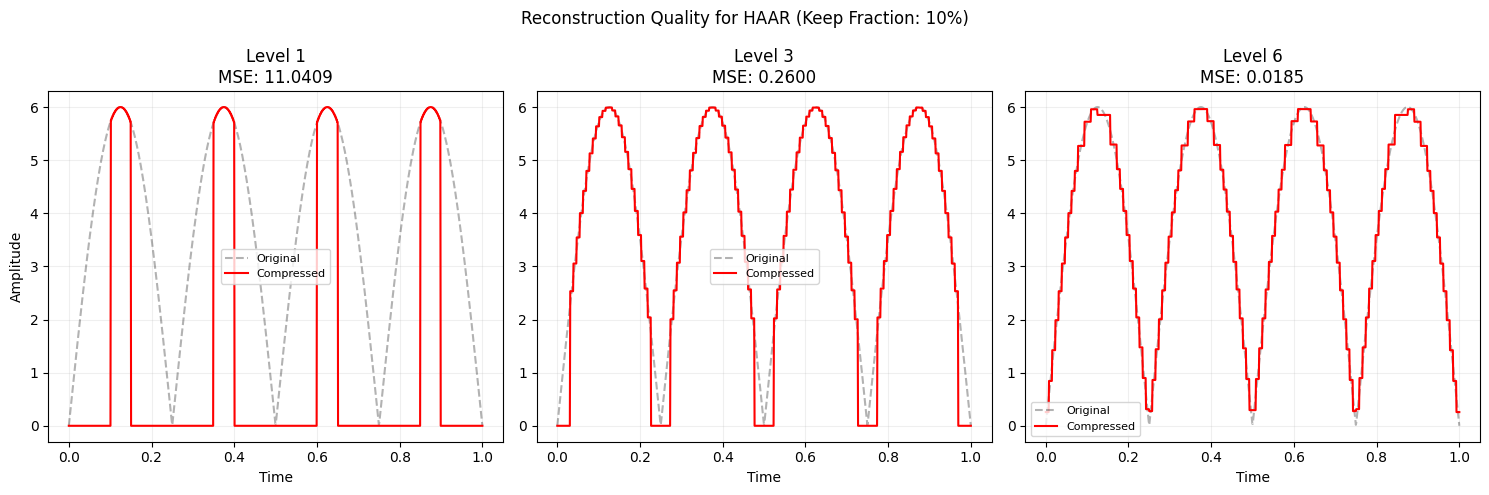

In [ ]:
def plot_reconstruction_comparison(signal, wavelet='haar', levels=[1, 3, 5], fraction=0.1):
    """
    Plots original vs reconstructed signals at different levels to visualize 
    why MSE changes.
    """
    t = np.linspace(0, 1, len(signal))
    plt.figure(figsize=(15, 5))
    
    for i, l in enumerate(levels):
        try:
            comp_sig, cr, mse, _ = dwt_compress_global(signal, wavelet=wavelet, level=l, keep_fraction=fraction)
            
            plt.subplot(1, len(levels), i+1)
            plt.plot(t, signal, 'k--', alpha=0.3, label='Original')
            plt.plot(t, comp_sig, 'r-', linewidth=1.5, label='Compressed')
            
            plt.title(f"Level {l}\nMSE: {mse:.4f}")
            plt.xlabel("Time")
            if i == 0: plt.ylabel("Amplitude")
            plt.legend(prop={'size': 8})
            plt.grid(True, alpha=0.2)
            
        except Exception as e:
            print(f"Level {l} failed: {e}")

    plt.suptitle(f"Reconstruction Quality for {wavelet.upper()} (Keep Fraction: {int(fraction*100)}%)")
    plt.tight_layout()
    plt.show()

# Execution
# Let's look at Level 1 vs Level 3 vs Level 6
plot_reconstruction_comparison(signal, wavelet='haar', levels=[1, 3, 6], fraction=0.1)

# Note the peak reconstruction quality seems to decrease as a function of level, this is because higher levels are incaple of capturing high frequency details due to their coarser resolution.

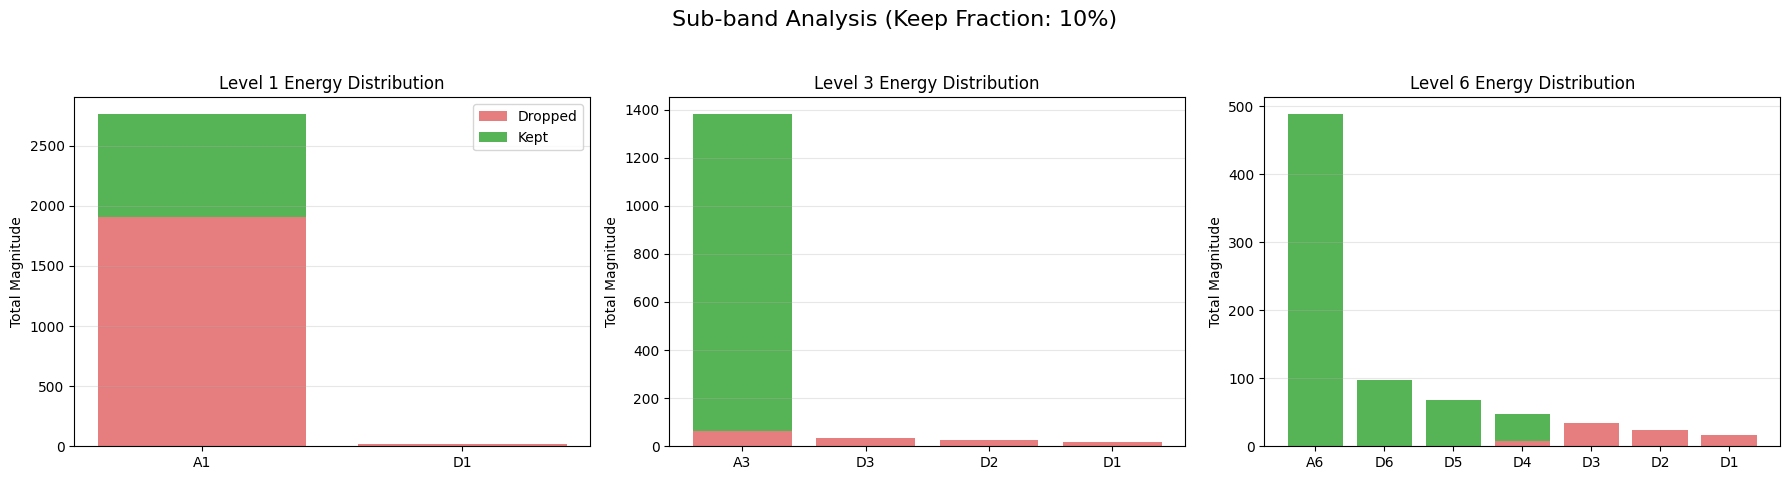

In [ ]:
def plot_subband_energy(signal, wavelet='haar', levels=[1, 3, 6], fraction=0.1):
    plt.figure(figsize=(18, 5))
    
    for i, l in enumerate(levels):
        # 1. Decompose the signal
        coeffs = pywt.wavedec(signal, wavelet, level=l)
        
        # 2. Flatten to find the global threshold (matching your dwt_compress_global logic)
        all_coeffs_flat = np.concatenate([c.flatten() for c in coeffs])
        thresh_val = np.percentile(np.abs(all_coeffs_flat), (1 - fraction) * 100)
        
        # 3. Calculate energy for each sub-band
        # Labeling: A{l}, D{l}, D{l-1} ... D1
        labels = [f"A{l}"] + [f"D{j}" for j in range(l, 0, -1)]
        
        kept_energy = []
        dropped_energy = []
        
        for c in coeffs:
            # Mask for coefficients above threshold
            mask = np.abs(c) >= thresh_val
            kept_energy.append(np.sum(np.abs(c[mask])))
            dropped_energy.append(np.sum(np.abs(c[~mask])))
        
        # Plotting
        ax = plt.subplot(1, len(levels), i + 1)
        
        # Stacked bar chart: Bottom is dropped (red), Top is kept (green)
        ax.bar(labels, dropped_energy, color='#d62728', alpha=0.6, label='Dropped')
        ax.bar(labels, kept_energy, bottom=dropped_energy, color='#2ca02c', alpha=0.8, label='Kept')
        
        ax.set_title(f"Level {l} Energy Distribution")
        ax.set_ylabel("Total Magnitude")
        if i == 0: ax.legend()
        ax.grid(axis='y', alpha=0.3)

    plt.suptitle(f"Sub-band Analysis (Keep Fraction: {int(fraction*100)}%)", fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# Execution
plot_subband_energy(signal, wavelet='haar', levels=[1, 3, 6], fraction=0.1)

In [ ]:
from scipy.optimize import minimize_scalar
import scipy.stats as stats
def wavelet_denoise_advanced(signal, wavelet_name='db4', level=5, threshold_method='universal', mode='soft'):
    coeffs = pywt.wavedec(signal, wavelet_name, level=level)
    # Global noise estimate (MAD)
    sigma = np.median(np.abs(coeffs[-1])) / 0.6745
    N = len(signal)
    
    new_coeffs = [coeffs[0]] # Keep approximation coefficients as-is
    
    for i in range(1, len(coeffs)):
        d_j = coeffs[i] # Detail coefficients at this level
        n_j = len(d_j)
        
        if threshold_method == 'universal':
            thresh = sigma * np.sqrt(2 * np.log(N))
            
        elif threshold_method == 'adaptive':
            # Level-dependent thresholding (BayesShrink style)
            # Estimate signal variance: sigma_y^2 = sigma_s^2 + sigma^2
            var_y = np.var(d_j)
            sigma_s = np.sqrt(max(var_y - sigma**2, 0))
            if sigma_s == 0:
                thresh = np.max(np.abs(d_j))
            else:
                thresh = (sigma**2) / sigma_s
                
        elif threshold_method == 'sure':
            # Rigrsure: Minimize Stein's Unbiased Risk Estimate
            thresh = _calculate_sure_threshold(d_j, sigma)
            
        elif threshold_method == 'fdr':
            # False Discovery Rate thresholding (q = 0.05)
            thresh = _calculate_fdr_threshold(d_j, sigma, q=0.05)
            
        else:
            raise ValueError(f"Unknown method: {threshold_method}")
            
        new_coeffs.append(pywt.threshold(d_j, thresh, mode=mode))

    return pywt.waverec(new_coeffs, wavelet_name)

def _calculate_sure_threshold(coeffs, sigma):
    """Finds the threshold that minimizes the SURE risk function."""
    n = len(coeffs)
    sorted_abs = np.sort(np.abs(coeffs))
    # Standard SURE risk calculation
    risks = []
    for i in range(n):
        t = sorted_abs[i]
        # Simplified SURE formula for soft thresholding
        risk = (n * sigma**2) + np.sum(np.minimum(coeffs**2, t**2) - 2 * sigma**2 * (np.abs(coeffs) <= t))
        risks.append(risk)
    return sorted_abs[np.argmin(risks)]

def _calculate_fdr_threshold(coeffs, sigma, q=0.05):
    """False Discovery Rate thresholding logic."""
    n = len(coeffs)
    p_values = 2 * (1 - stats.norm.cdf(np.abs(coeffs) / sigma))
    sorted_p = np.sort(p_values)
    
    # Find the largest i such that P_(i) <= (i/n) * q
    indices = np.arange(1, n + 1)
    allowed = sorted_p <= (indices / n) * q
    if not np.any(allowed):
        return sigma * np.sqrt(2 * np.log(n)) # Fallback to universal
    
    idx = np.max(np.where(allowed))
    return sigma * stats.norm.ppf(1 - (sorted_p[idx] / 2))


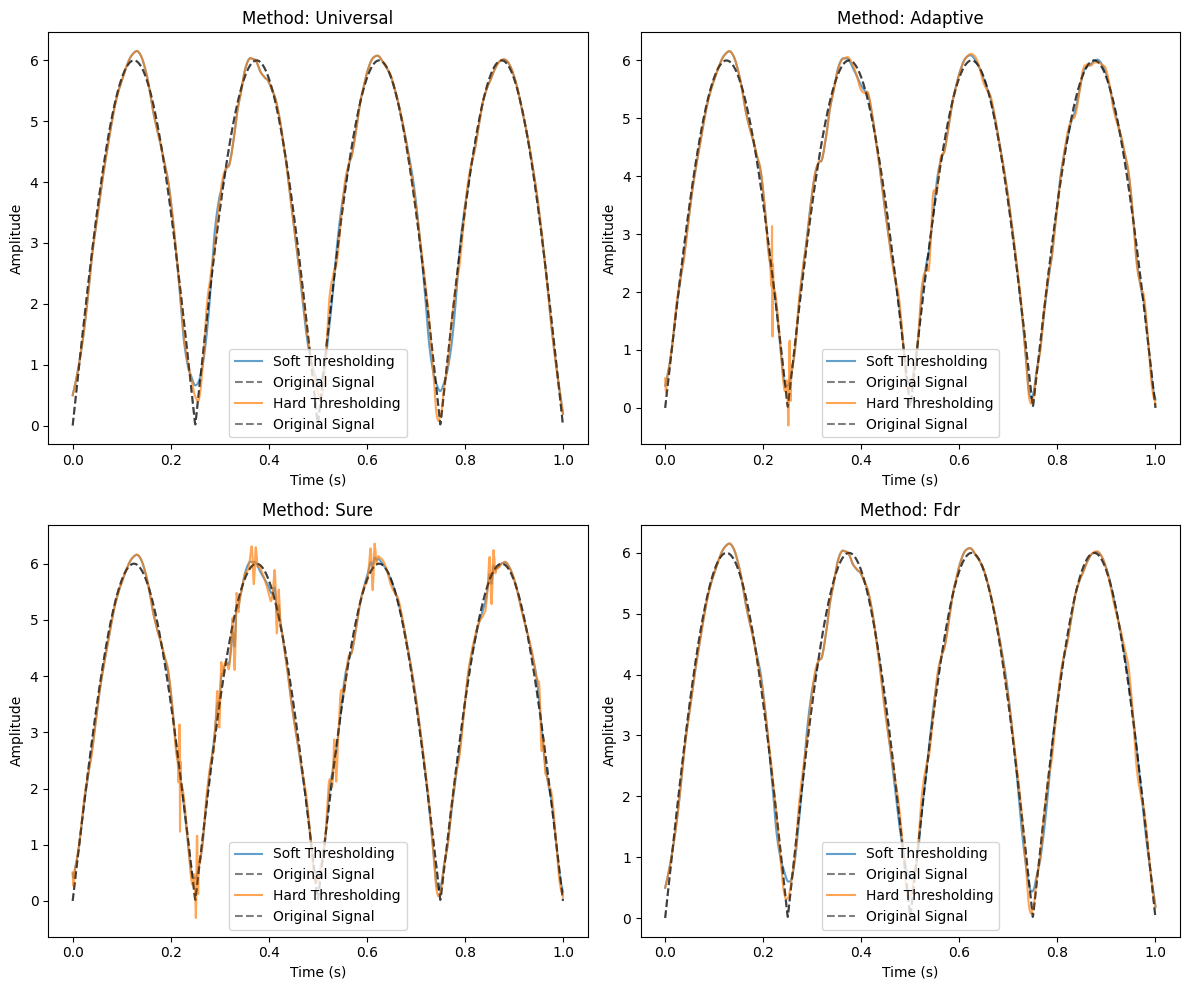

In [ ]:
# Plot in a 2x2 grid with different methods, with a soft and hard version in each
plt.figure(figsize=(12, 10))
methods = ['universal', 'adaptive', 'sure', 'fdr']
for i, method in enumerate(methods):
    for j, mode in enumerate(['soft', 'hard']):
        plt.subplot(2, 2, i+1)
        denoised = wavelet_denoise_advanced(noisy_signal, wavelet_name='db4', level=5, threshold_method=method, mode=mode)
        plt.plot(t, denoised, label=f'{mode.capitalize()} Thresholding', alpha=0.7)
        plt.title(f"Method: {method.capitalize()}")
        plt.xlabel("Time (s)")
        plt.ylabel("Amplitude")
        plt.plot(t, signal, 'k--', alpha=0.5, label='Original Signal')
        plt.legend()
plt.tight_layout()
plt.show()


Universal (VisuShrink): Uses a fixed global threshold $\sigma \sqrt{2 \log(N)}$ designed to remove all noise with high probability. It produces the smoothest results but often over-smooths sharp features.

Adaptive (BayesShrink): Calculates a level-dependent threshold based on estimated signal variance ($\sigma^2 / \sigma_s$). It is best suited at preserving edges by adapting to the specific energy of each frequency subband.

SURE (Rigrsure): Minimizes Stein’s Unbiased Risk Estimate to find a mathematically "optimal" threshold for each level. It is highly detailed but can become unstable if the noise level is high relative to the signal.

FDR (False Discovery Rate): Controls the proportion of false positives among the detected coefficients using statistical p-values. It is ideal for sparse, spiky data but may leave "speckle" noise in continuous signals.

The reason that SURE and FDR struggels, is because the signal is smooth and non-sparse. The assumptions of SURE and FDR is to look for rare, high-magnitude discoveries. When faced with a continues wave, they underestimate the required threshold, which ends up mistaking noise spikes as valid. 

In [ ]:
# Wavelets transforms as informal test for non-stationarity
# Wavelets for smoothing and detrending time series
# DWT requies a dyadic length signal (2^N), i.e. 256, 512, 1024, ...
# Thresholding as signal extraction
# Wavelets for outlier detection